### A hands-on testing of *CNTK_102*
https://github.com/Microsoft/CNTK/blob/v2.0.beta3.0/bindings/python/tutorials/CNTK_103B_MNIST_FeedForwardNetwork.ipynb

In [2]:
import sys, os
import getpass
import cntk.ops as C
from cntk.models import Sequential
from cntk.layers import Dense
from cntk.trainer import Trainer
from cntk.learner import sgd
from cntk.io import StreamConfiguration, text_format_minibatch_source
from cntk.utils import get_train_loss, get_train_eval_criterion

import numpy as np
import matplotlib.pyplot as plt

## model1
### prepare training data

In [3]:
mnist_dir = '/home/' + getpass.getuser() + '/repos/cntk/Examples/Image/DataSets/MNIST/'
train_file = mnist_dir + "Train-28x28_cntk_text.txt"
test_file = mnist_dir + "Test-28x28_cntk_text.txt"

input_dim = 784
hidden_layers_dim = 400
num_output_classes = 10
features_stream_name = 'features'
labels_stream_name = 'labels'
mb_source = text_format_minibatch_source(train_file, [
        StreamConfiguration(features_stream_name, input_dim),
        StreamConfiguration(labels_stream_name, num_output_classes)
    ])
features_si = mb_source[features_stream_name]
labels_si = mb_source[labels_stream_name]
print (mb_source)
print (features_si)

<cntk.io.MinibatchSource; proxy of <Swig Object of type 'CNTK::MinibatchSourcePtr *' at 0x7fd30538e930> >
<cntk.cntk_py.StreamInformation; proxy of <Swig Object of type 'CNTK::StreamInformation *' at 0x7fd32c5f65a0> >


### build mode

In [4]:
input = C.input_variable(input_dim, np.float32)
label = C.input_variable(num_output_classes, np.float32)
scaled_input = C.element_times(C.constant(0.00390625), input)
#scaled_input = input
model = Sequential([Dense(hidden_layers_dim, activation=C.relu),
                    Dense(hidden_layers_dim, activation=C.relu),
                    Dense(num_output_classes)])
model = model(scaled_input)
cross_entropy = C.cross_entropy_with_softmax(model, label)
error = C.classification_error(model, label)
trainer = Trainer(model=model, loss_function=cross_entropy, eval_function=error,
                            parameter_learners=sgd(model.parameters, lr=0.003125))

In [5]:
def print_training_progress(trainer, ii, freq, verbose=0):
    previous_minibatch_loss = 'NA'
    previous_minibatch_eval = 'NA'
    if ii % freq == 0:
        previous_minibatch_loss = get_train_loss(trainer)
        previous_minibatch_eval = get_train_eval_criterion(trainer)
        if verbose:
            print ('mb_num: {0}, loss: {1}, eval: {2}'.format(ii, previous_minibatch_loss, previous_minibatch_eval))
    return ii, previous_minibatch_loss, previous_minibatch_eval
#Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [6]:
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    mb = mb_source.next_minibatch(minibatch_size)
    
    # Specify the input variables mapping in the model to actual minibatch data to be trained
    arguments = {input: mb[features_si],
                 label: mb[labels_si]}
    trainer.train_minibatch(arguments)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)



mb_num: 0, loss: 2.332737684249878, eval: 0.859375
mb_num: 500, loss: 0.11965678632259369, eval: 0.03125
mb_num: 1000, loss: 0.04597800225019455, eval: 0.0
mb_num: 1500, loss: 0.08307366818189621, eval: 0.03125
mb_num: 2000, loss: 0.08662894368171692, eval: 0.03125
mb_num: 2500, loss: 0.122032530605793, eval: 0.0625
mb_num: 3000, loss: 0.04000946879386902, eval: 0.015625
mb_num: 3500, loss: 0.03271634131669998, eval: 0.015625
mb_num: 4000, loss: 0.008563652634620667, eval: 0.0
mb_num: 4500, loss: 0.05894005671143532, eval: 0.015625
mb_num: 5000, loss: 0.01672682911157608, eval: 0.0
mb_num: 5500, loss: 0.0009536147117614746, eval: 0.0
mb_num: 6000, loss: 0.024255208671092987, eval: 0.015625
mb_num: 6500, loss: 0.01815439760684967, eval: 0.0
mb_num: 7000, loss: 0.0031032413244247437, eval: 0.0
mb_num: 7500, loss: 0.007541164755821228, eval: 0.0
mb_num: 8000, loss: 0.001094222068786621, eval: 0.0
mb_num: 8500, loss: 0.0026490390300750732, eval: 0.0
mb_num: 9000, loss: 0.003599971532821655

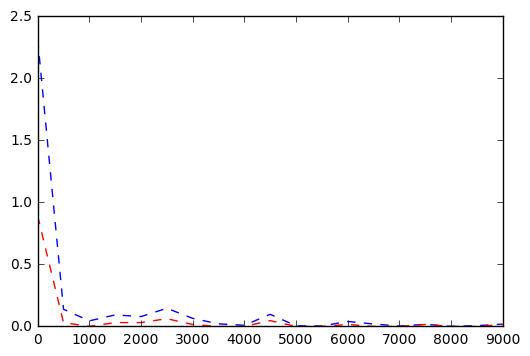

In [19]:
plt.plot(plotdata['batchsize'], plotdata['loss'], '--')
plt.plot(plotdata['batchsize'], plotdata['error'], '--', c='r')
plt.show()

### test model

In [20]:
mb_source_test = text_format_minibatch_source(test_file, [
        StreamConfiguration(features_stream_name, input_dim),
        StreamConfiguration(labels_stream_name, num_output_classes)
    ])
features_si_test = mb_source_test[features_stream_name]
labels_si_test = mb_source_test[labels_stream_name]

In [21]:
# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples / test_minibatch_size
test_result = 0.0
for ii in range(0, int(num_minibatches_to_test)):
    mb_test = mb_source_test.next_minibatch(test_minibatch_size)
    error_per_sample = trainer.test_minibatch({input: mb_test[features_si_test], label: mb_test[labels_si_test]})
    test_result += error_per_sample

print ('test error per sample: {0}'.format(test_result/int(num_minibatches_to_test)))

test error per sample: 0.019942434210526317


In [23]:
output = C.softmax(model)

In [59]:
mb = mb_source_test.next_minibatch(20)
y_pred = output.eval({input: mb[features_si_test]})[:, 0, :]
y_true = np.asarray(mb[labels_si_test].m_data)[:, 0, :]
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)
prd_wroung = [ii for ii in range(len(y_pred)) if y_pred[ii]!=y_true[ii]]
print (y_pred)
print (y_true)
print (prd_wroung)

[5 2 6 7 2 1 4 9 5 6 8 2 2 7 5 9 7 8 8 9]
[5 2 6 7 2 1 4 9 5 6 8 2 1 7 5 4 7 8 8 9]
[12, 15]


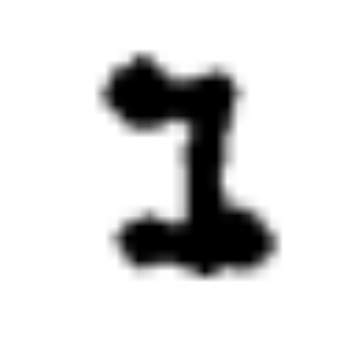

In [64]:
if len(prd_wroung) > 0:
    idx = prd_wroung[0]
else:
    idx = 0
mat = mb[features_si_test].value
plt.imshow(mat[idx, :, :].reshape(28, 28), cmap='gray_r')
plt.axis('off')
plt.show()

## model2 
**(the *input* is numpy.ndarray type which differs from the above model)**
### prepare data

In [80]:
import sys
sys.path.append('/home/' + getpass.getuser() + '/git_test/')
from Teemo.examples.mnist import load_data
from Teemo.algorithm.utils import matrixops
trn_x, trn_y, valid_x, valid_y = load_data.mnist()
trn_x = np.asarray(trn_x, dtype=np.float32)
trn_y = np.asarray(trn_y, dtype=np.float32)
valid_x = np.asarray(valid_x, dtype=np.float32)
valid_y = np.asarray(valid_y, dtype=np.float32)
print ('load data sucessfully')

load data sucessfully


### build mode

In [81]:
input = C.input_variable(input_dim, np.float32)
label = C.input_variable(num_output_classes, np.float32)
#scaled_input = C.element_times(C.constant(0.00390625), input)
scaled_input = input
model = Sequential([Dense(hidden_layers_dim, activation=C.relu),
                    Dense(hidden_layers_dim, activation=C.relu),
                    Dense(num_output_classes)])
model = model(scaled_input)
cross_entropy = C.cross_entropy_with_softmax(model, label)
error = C.classification_error(model, label)
trainer = Trainer(model=model, loss_function=cross_entropy, eval_function=error,
                            parameter_learners=sgd(model.parameters, lr=0.003125))

In [82]:
training_progress_output_freq = 500
plotdata = {"batchsize":[], "loss":[], "error":[]}

max_jj = 0
for ii in range(10):
    jj = 0
    for mb_x, mb_y in matrixops.iterate_minibatches(minibatch_size, trn_x, trn_y, shuffle=True):
        trainer.train_minibatch({input:mb_x, label:mb_y})
        batchsize, loss, error = print_training_progress(trainer, ii*max_jj + jj, training_progress_output_freq, verbose=1)
        jj += 1
        if not (loss == "NA" or error =="NA"):
            plotdata["batchsize"].append(batchsize)
            plotdata["loss"].append(loss)
            plotdata["error"].append(error)

    max_jj = jj

mb_num: 0, loss: 2.345682382583618, eval: 0.890625
mb_num: 500, loss: 0.1337813287973404, eval: 0.046875
mb_num: 1000, loss: 0.16308051347732544, eval: 0.046875
mb_num: 1500, loss: 0.1904614269733429, eval: 0.0625
mb_num: 2000, loss: 0.01738615334033966, eval: 0.0
mb_num: 2500, loss: 0.02501310408115387, eval: 0.0
mb_num: 3000, loss: 0.02971567213535309, eval: 0.015625
mb_num: 3500, loss: 0.01777563989162445, eval: 0.0
mb_num: 4000, loss: 0.010875910520553589, eval: 0.0
mb_num: 4500, loss: 0.02084767073392868, eval: 0.0
mb_num: 5000, loss: 0.008714616298675537, eval: 0.0
mb_num: 5500, loss: 0.055848732590675354, eval: 0.015625
mb_num: 6000, loss: 0.03329751640558243, eval: 0.03125
mb_num: 6500, loss: 0.047362007200717926, eval: 0.03125
mb_num: 7000, loss: 0.0077372267842292786, eval: 0.0
mb_num: 7500, loss: 0.007033608853816986, eval: 0.0
mb_num: 8000, loss: 0.003890886902809143, eval: 0.0
mb_num: 8500, loss: 0.0027677714824676514, eval: 0.0
mb_num: 9000, loss: 0.0034391283988952637, e

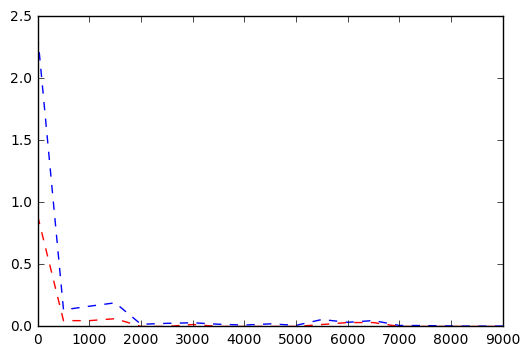

In [83]:
plt.plot(plotdata['batchsize'], plotdata['loss'], '--')
plt.plot(plotdata['batchsize'], plotdata['error'], '--', c='r')
plt.show()

In [84]:
# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples / test_minibatch_size
test_result = 0.0

for mb_x, mb_y in matrixops.iterate_minibatches(test_minibatch_size, valid_x, valid_y, shuffle=True):
    error_per_sample = trainer.test_minibatch({input: mb_x, label: mb_y})
    test_result += error_per_sample

print ('test error per sample: {0}'.format(test_result/int(num_minibatches_to_test)))

test error per sample: 0.01777767027863777


In [85]:
output = C.softmax(model)

In [116]:
num_test = 500
mb_x = valid_x[:num_test]
mb_y = valid_y[:num_test]
y_pred = output.eval({input: mb_x})[0, :, :]
y_true = mb_y
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)
prd_wroung = [ii for ii in range(len(y_pred)) if y_pred[ii]!=y_true[ii]]

print ('predicted value:    {0}'.format([y_pred[ii] for ii in prd_wroung]))
print ('ground truth value: {0}'.format([y_true[ii] for ii in prd_wroung]))

predicted value:    [2, 7, 3, 0, 5, 2]
ground truth value: [4, 2, 5, 6, 3, 8]


wroung


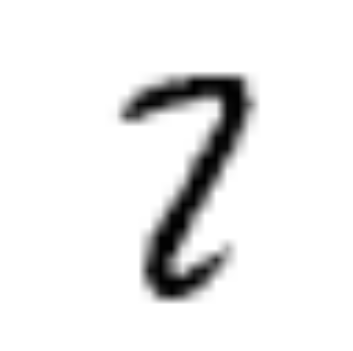

In [117]:
if len(prd_wroung) > 0:
    idx = prd_wroung[1]
    print ('wroung')
else:
    idx = 0
plt.imshow(mb_x[idx].reshape(28, 28), cmap='gray_r')
plt.axis('off')
plt.show()